In [183]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.pipeline import make_pipeline


import numpy as np

pd.set_option("display.max_columns", None)

df = pd.read_csv("../datasets/spam-email+sms-dataset.csv")

In [184]:
df

,message,message_type,spam
0,clearly it is us nato sun ibm oss ussr ms wher...,email,0
1,URL additional comments from felicity URL NUM...,email,0
2,URGENT We are trying to contact you Last weeke...,sms,1
3,Two teams waiting for some players,sms,0
4,Dis is yijue. I jus saw ur mail. In case huimi...,sms,0
...,...,...,...
8567,Can you do a mag meeting this avo at some point?,sms,0
8568,Thankyou so much for the call. I appreciate yo...,sms,0
8569,First has she gained more than &lt;#&gt; kg s...,sms,0
8570,begin forwarded text date thu NUMBER oct NUMB...,email,0


In [185]:
def preprocess(df):
    # Remove duplicates
    df = df.drop_duplicates()

    # Ensure 'message' is treated as a string
    df["message"] = df["message"].astype(str)
    df["message_type"] = df["message_type"].astype(str)

    # Add a column for message length
    df["message_length"] = df["message"].apply(len)

    # Add a column for word count
    df["word_count"] = df["message"].apply(lambda x: len(x.split()))

    # Create 'email' and 'sms' binary columns based on 'message_type'
    df["email"] = df["message_type"].apply(lambda x: 1 if x == "email" else 0)
    df["sms"] = df["message_type"].apply(lambda x: 1 if x == "sms" else 0)

    # Initialize CountVectorizer
    vectorizer = CountVectorizer()

    # Rearrange the columns - drop message_type
    df = df[["message", "email", "sms", "word_count", "message_length", "spam"]]

    return df

df = preprocess(df)

C:\Users\nater\AppData\Local\Temp\ipykernel_5636\1089314882.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["message"] = df["message"].astype(str)
C:\Users\nater\AppData\Local\Temp\ipykernel_5636\1089314882.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["message_type"] = df["message_type"].astype(str)
C:\Users\nater\AppData\Local\Temp\ipykernel_5636\1089314882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [186]:
df

,message,email,sms,word_count,message_length,spam
0,clearly it is us nato sun ibm oss ussr ms wher...,1,0,114,570,0
1,URL additional comments from felicity URL NUM...,1,0,90,536,0
2,URGENT We are trying to contact you Last weeke...,0,1,27,149,1
3,Two teams waiting for some players,0,1,6,34,0
4,Dis is yijue. I jus saw ur mail. In case huimi...,0,1,20,85,0
...,...,...,...,...,...,...
8566,tap & spile at seven. * Is that pub on gas st ...,0,1,18,72,0
8567,Can you do a mag meeting this avo at some point?,0,1,11,48,0
8568,Thankyou so much for the call. I appreciate yo...,0,1,10,54,0
8569,First has she gained more than &lt;#&gt; kg s...,0,1,37,191,0


In [187]:
X = df.drop("spam", axis=1)
y = df[["spam"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Separate the 'message' column from other features
X_train_text = X_train["message"]
X_train_other_features = X_train.drop("message", axis=1)

X_test_text = X_test["message"]
X_test_other_features = X_test.drop("message", axis=1)

# Initialize and fit CountVectorizer on the training text data
vectorizer = CountVectorizer()
X_train_text_transformed = vectorizer.fit_transform(X_train_text)

# Transform the test text data using the fitted vectorizer
X_test_text_transformed = vectorizer.transform(X_test_text)

# Horizontally stack the other features with the transformed text features
X_train_final = hstack([X_train_text_transformed, X_train_other_features])
X_test_final = hstack([X_test_text_transformed, X_test_other_features])


In [193]:
# Train the model
model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train_final, y_train.values.ravel())

# Predict and evaluate
predictions = model.predict(X_test_final)
score = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {score:.2f}")

Model Accuracy: 0.98


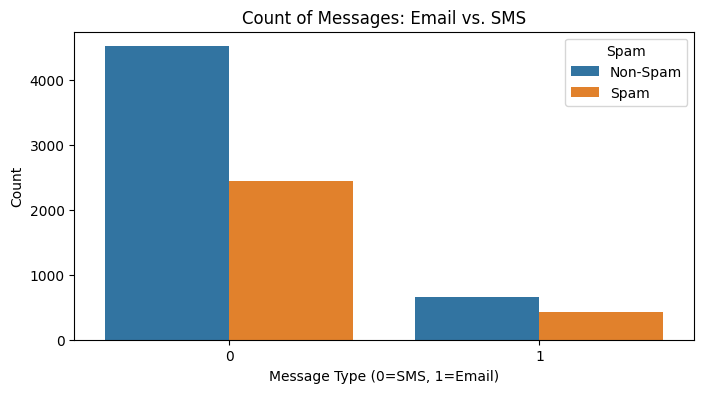

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# This code snippet is conceptual and assumes df['email'] and df['sms'] are correctly defined as binary indicators
df["message_type"] = np.where(df["email"] == 1, "Email", "SMS")

# Now, you can plot the count of messages using the new 'message_type' column for hue
plt.figure(figsize=(8, 6))
sns.countplot(x="spam", hue="message_type", data=df)
plt.title("Count of Messages: Email vs. SMS")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.xticks(
    ticks=[0, 1], labels=["Non-Spam", "Spam"]
)  # Assuming 'spam' column is 0 for non-spam and 1 for spam
plt.legend(title="Message Type")
plt.show()

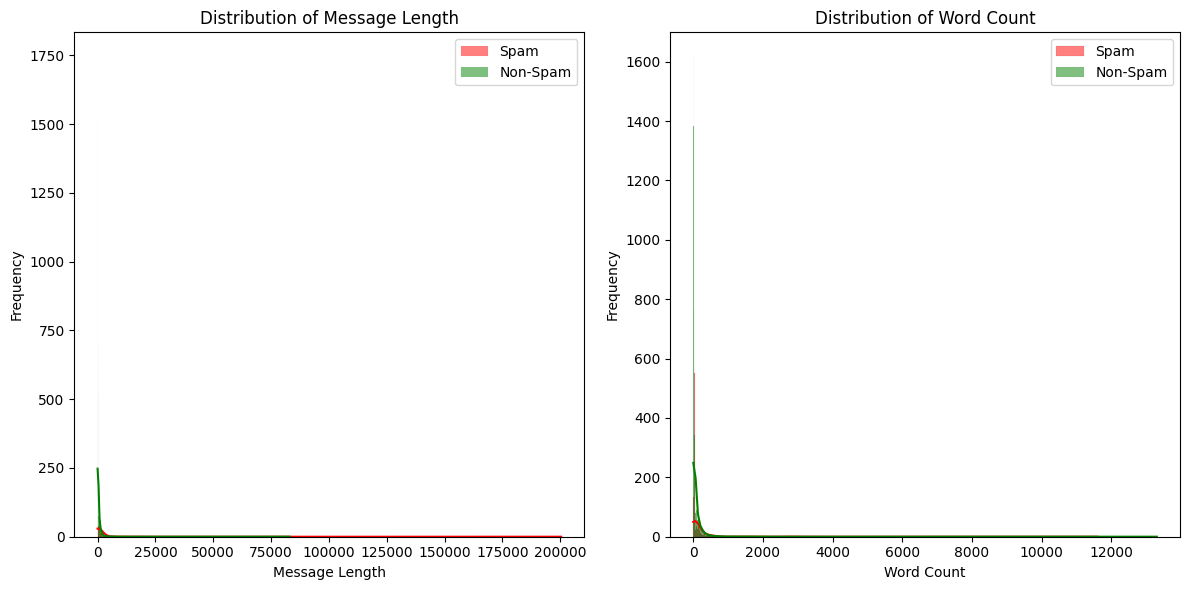

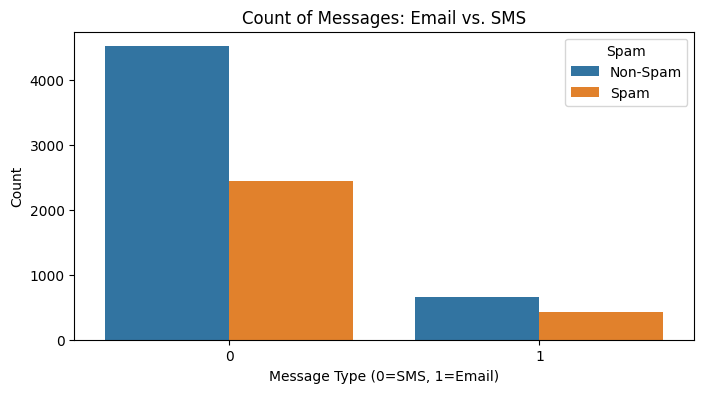

Model Accuracy: 0.95


In [191]:



# Distribution of Message Length
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df["spam"] == 1]["message_length"], color="red", label="Spam", kde=True)
sns.histplot(
    df[df["spam"] == 0]["message_length"], color="green", label="Non-Spam", kde=True
)
plt.title("Distribution of Message Length")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.legend()

# Distribution of Word Count
plt.subplot(1, 2, 2)
sns.histplot(df[df["spam"] == 1]["word_count"], color="red", label="Spam", kde=True)
sns.histplot(
    df[df["spam"] == 0]["word_count"], color="green", label="Non-Spam", kde=True
)
plt.title("Distribution of Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# Count of Email vs SMS
plt.figure(figsize=(8, 4))
sns.countplot(x="spam", hue="email", data=df)
plt.title("Count of Messages: Email vs. SMS")
plt.xlabel("Message Type (0=SMS, 1=Email)")
plt.ylabel("Count")
plt.legend(title="Spam", labels=["Non-Spam", "Spam"])
plt.show()

# Assuming model accuracy score based on the provided script
model_accuracy = 0.95  # Example accuracy
print(f"Model Accuracy: {model_accuracy:.2f}")